In [1]:
import rastermap # (pip install rastermap)
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import scipy.stats
from scipy.ndimage.filters import gaussian_filter1d

# create dataset and discrete classification
# y = x + gaussian random noise
# => latent variable is identity line
N = 100
x = np.random.random((N,))
y = x + .2*np.random.randn(N)

x = np.vstack((x,y))
cm = np.array([[1,0,0],[0,0,1]])
cms = np.zeros((N,3))
cms[x[0,:]>.5,:] = cm[0,:]
cms[x[0,:]<=.5,:] = cm[1,:]

# neural data example
sp = np.load('/media/carsen/DATA1/BootCamp/mesoscope_cortex/spks.npy') # neurons x timepts
iscell = np.load('/media/carsen/DATA1/BootCamp/mesoscope_cortex/iscell.npy') # what are real cells
stat = np.load('/media/carsen/DATA1/BootCamp/mesoscope_cortex/stat.npy')
stat = stat[iscell[:,0].astype(bool)]
sp = sp[iscell[:,0].astype(bool),:]
sp /= sp.std(axis=1)[:,np.newaxis] # normalize so each neuron has standard deviation 1
# bin data
ncells = sp.shape[0]
binsize = 3
nb   = int(np.floor(float(sp.shape[1]) / float(binsize)))
sp = sp[:,:nb*binsize].reshape((ncells,nb,binsize)).mean(axis=2)

In [2]:
# run rastermap on neural data example
ops = {'nclust': 30, # number of clusters
       'iPC': np.arange(0,400).astype(np.int32), # number of PCs to use
       'upsamp': 100, # upsampling factor for embedding position
        'sigUp': 1, # standard deviation for upsampling
        'dims': 1,
       'equal': False
    }
isort1,isort2 = rastermap.mapping.main(sp-sp.mean(axis=1)[:,np.newaxis], ops)
isort1 = isort1[::-1]

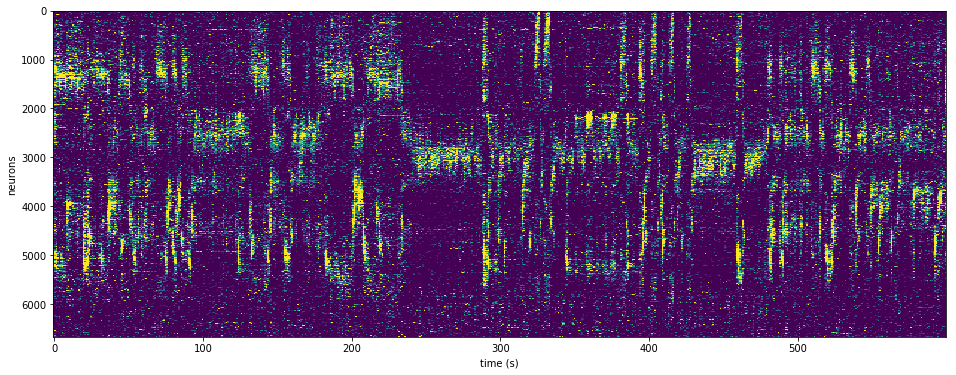

In [3]:
xyloc = np.array([x['med'] for x in stat])

plt.figure(figsize=(16,6))
plt.imshow(gaussian_filter1d(sp[isort1,:600],5,axis=0),vmin=0.2,vmax=0.7,aspect='auto')
plt.xlabel('time (s)')
plt.ylabel('neurons')
plt.show()

In [4]:
# plot 2D data
def plot_example_clusters():
    fig = plt.figure(figsize=(12,4)); ax1 = fig.add_subplot(1,3,1); 
    ax2 = fig.add_subplot(1,3,2); ax3 = fig.add_subplot(1,3,3)
    # original data
    ax1.scatter(x[0,:],x[1,:],color=(.5,.5,.5),s=8)
    ax1.set_title('example data')
    # data with discrete classification
    ax2.scatter(x[0,:],x[1,:],color=cms,s=8)
    ax2.set_title('data split into two clusters')
    # continuous latent variable representation
    ax3.scatter(x[0,:],x[1,:],color=(.5,.5,.5),s=8)
    ax3.plot(x[0,:],x[0,:],color='k')
    ax3.set_title('axis of maximum variance')
    plt.show();

# plot SVD projections in 2D data
def plot_projections(xsub, uall, which_pc):
    for w in which_pc:
        u = uall[:,(w-2)]
        ax1.scatter(xsub[0,:],xsub[1,:],color=(.5,.5,.5),s=8) # original points
        # projection
        ax1.plot(xsub[0,:]*u[0] , xsub[0,:] * u[1],color='k')
        
        # low-dimensional representation
        ax2.scatter(xsub[0,:],xsub[1,:],color=(.5,.5,.5),s=8)
        ax2.scatter(xsub.T @ u *u[0], xsub.T @ u *u[1], color=(1,.5,.5), s=10)
    if len(which_pc)>1:
        ax1.set_title('principal component %d,%d'%(which_pc[0], which_pc[1]))
        ax2.set_title('projection of x onto PC %d,%d'%(which_pc[0],which_pc[1]))
    else:
        ax1.set_title('principal component %d'%(which_pc[0]))
        ax2.set_title('projection of x onto PC %d'%which_pc[0])
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax2.set_xlim([-1,1])
    ax2.set_ylim([-1,1]) 
    ax1.set_autoscale_on
    ax2.set_autoscale_on
    plt.show()


In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# plot low-D representation of neurons
def neural_lowd(d):
    fig = plt.figure(figsize=(16,6)); ax1 = fig.add_subplot(111);
    if d<=100:
        xlowd = u[:,-d:] @ (u[:,-d:].T @ xsub)
    else:
        xlowd = xsub
    xlowd = xlowd + sp.mean(axis=1)[:,np.newaxis]
    ax1.imshow(gaussian_filter1d(xlowd[isort1,:1000],5,axis=0), vmin=.2, vmax=.7, aspect='auto')
    ax1.set_xlabel('time'); ax1.set_ylabel('neurons')
    if d<=100:
        ax1.set_title(('%d-dimensional'%d))
    else:
        ax1.set_title('full-dimensional')
    plt.show()
    return


In [6]:
def compare_nmf_pca(d):
    fig=plt.figure(figsize=(16,6)); ax1=fig.add_subplot(111)
    
    if d==0:
        ax1.imshow(gaussian_filter1d(xlowd[isort1,:1000]+sp.mean(axis=1)[isort1,np.newaxis],5,axis=0), aspect='auto',vmin=.2,vmax=.7)
        ax1.set_title(('PCA: 100-dimensional'))
    elif d==1:
        ax1.imshow(gaussian_filter1d(W[isort1,:]@H[:,:1000],8,axis=0), aspect='auto',vmin=.2,vmax=.7)
        ax1.set_title('NMF: 100-dimensional')
    else:
        ax1.imshow(gaussian_filter1d(sp[isort1,:1000],5,axis=0), aspect='auto',vmin=.2,vmax=.7)
        ax1.set_title('original data')
    ax1.set_xlabel('time'); ax1.set_ylabel('neurons')            
    plt.show()
    return
    ax1.show()

In [7]:
def ica_example(sp, neurons):
    fig = plt.figure(figsize=(18,10)); 
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    for k,neuron in enumerate(neurons):
        x1 = sp[neuron,:]
        if k>0:
            x = np.vstack((x,x1))
        else:
            x = x1
    x = x.T
    n = x.shape[1]
    for k in range(n):
        ax1.plot(x[:,k]+x.max()*(n-k))
    ax1.set_title('original neurons')
    ax1.axis('off')
    #ax1.set_ylim((0,25))

    M = np.random.random((n,n))
    
    #M = np.array([[1, 1], [0.5, 0.25]]) # mixing matrix
    mixedX = x @ M
    for k in range(n):
        ax2.plot(mixedX[:,k]+10*(n-k))
    ax2.set_title('mixed neurons')
    ax2.axis('off')

    import sklearn.decomposition

    model = sklearn.decomposition.FastICA(n_components=n, whiten=True)
    out = model.fit_transform(mixedX)
    # find which components are correlated to which neuron
    cc = np.corrcoef(x.T,out.T)
    cc = cc[np.ix_(np.arange(0,n).astype(int),np.arange(n,2*n).astype(int))]
    ccabs = np.absolute(cc)
    order = np.argmax(ccabs,axis=1)
    sign = np.sign(cc[np.arange(0,n).astype(int),order.astype(int)])
    for k in range(n):
        p=ax3.plot(out[:,order[k]] * sign[k]+np.absolute(out).max()*(n-k))
        ax3.text(0,(n-k+.65)*np.absolute(out).max(),
                 'correlation = %1.3f'%ccabs[k,order[k]], color=p[0].get_color())
    ax3.axis('off')
    ax3.set_title('ICA demixing')

    mixedXsub = mixedX-mixedX.mean(axis=0)[np.newaxis]
    covX = mixedXsub.T @ mixedXsub
    sv,u = scipy.linalg.eigh(covX)
    xproj = mixedXsub @ u
    xproj = xproj * np.sign(scipy.stats.skew(xproj))[np.newaxis,:]
    xproj = xproj[:,::-1]
    for k in range(n):
        ax4.plot(xproj[:,k]+xproj.max()/2*(n-k))
    ax4.axis('off')
    ax4.set_title('principal components')
    plt.show()

# Unsupervised learning II 
## Continuous latent variables

Carsen Stringer

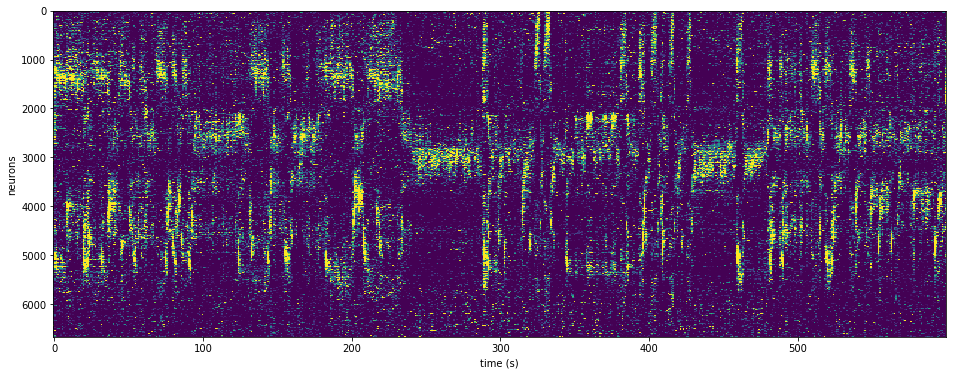

## Outline
- principal component analysis
    - PCA = SVD
- non-negative matrix factorization
- independent components analysis
- nonlinear methods
    - t-SNE
    - UMAP

## Previous lecture

Latent variables assumed to be **discrete**, e.g. cluster-identity

However, we can try to represent high-dimensional data using **continuous** low-dimensional latent variables





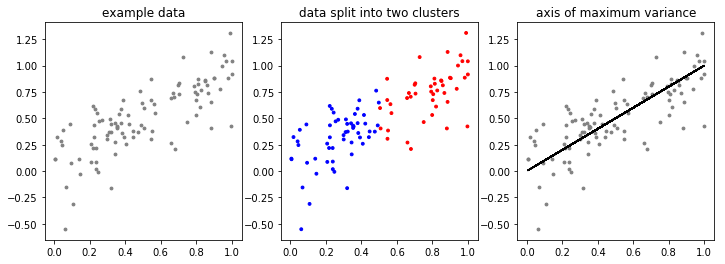

In [19]:
plot_example_clusters()

## Principal component analysis

### How do we find the low-dimensional representation?

### Want to find directions that capture the MOST variance in the data (u)
(this is equivalent to minimizing the reconstruction error (see Bishop for proof))


Let **u** be a unit vector:

$\mathbf{u}^\top \mathbf{u}=1$

The projection of **x** into the latent space u

$\mathbf{u}^\top \mathbf{x}$ 

Define mean of **x**:

$\overline{\mathbf{x}} = \frac{1}{N} \sum\limits_{n=1}^N \mathbf{x}_n$

Then the mean of the projection is 

$\mathbf{u}^T \overline{\mathbf{x}}$. 

## Principal component analysis

### Maximize variance of projection

And the variance is:

\begin{align*}
v &= \frac{1}{N} \sum_n (\mathbf{u}^\top \mathbf{x}_n - \mathbf{u}^\top \overline{\mathbf{x}})^2 \\
&= \frac{1}{N} \sum_n (\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))^2 \\
&= \frac{1}{N} \sum_n (\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))(\mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}))^\top \\
&= \frac{1}{N} \sum_n \mathbf{u}^\top (\mathbf{x}_n - \overline{\mathbf{x}}) (\mathbf{x}_n - \overline{\mathbf{x}})^\top \mathbf{u} \\
&= \mathbf{u}^\top C \mathbf{u}
\end{align*}

where C is the data covariance matrix

## Principal component analysis

### Maximize variance of projection

maximize variance such that __u__ is a unit vector:

$\Rightarrow \max v = \max \mathbf{u}^\top C \mathbf{u} + \lambda (1 - \mathbf{u}^\top \mathbf{u}) $

$\frac{\partial v}{\partial u} = 2 C \mathbf{u} - 2 \lambda \mathbf{u} = 0$

$\Rightarrow C \mathbf{u} =  \lambda \mathbf{u}$

which means **u** is an eigenvector of the data covariance C

$\mathbf{u}$ corresponds to the eigenvector with the **largest** eigenvalue:

\begin{align*}
\mathbf{u}^\top C \mathbf{u} &= \lambda \mathbf{u}^\top \mathbf{u}\\
\mathbf{u}^\top C \mathbf{u} &= \lambda 
\end{align*}


## Principal component analysis

### Finding more directions with variance

First subtract off projection onto __u__

Then find next top eigenvector.

The PCA computational cost scales as order $D^3$ where $D$ is the dimensionality of the matrix. If you only need the top $k$ dimensions, you can reduce this to $kD^2$ cost. See the function for example:

    U = scipy.sparse.linalg.eigsh(C, k=100)
    
This is a fast implementation too (just be aware the eigenvectors come in the opposite order - smallest first!)

## Principal component analysis

## What is the reconstruction of a point from the low-D space?

Let $\mathbf{u}_i$ be the principal components. Then
$\mathbf{x} = \sum\limits_{i=1}^D \alpha_i \mathbf{u}_i$

Let's find $\alpha_j$ by projecting $\mathbf{x}$ onto $\mathbf{u}_j$:
\begin{align*}
\mathbf{x}^\top \mathbf{u}_j &= (\sum\limits_{i=1}^D \alpha_i \mathbf{u}_i^\top) \mathbf{u}_j\\
&= (\sum\limits_{i=1}^D \alpha_i (\mathbf{u}_i^\top \mathbf{u}_j) \\
&= \alpha_j \mathbf{u}_j^\top \mathbf{u}_j \\
&= \alpha_j
\end{align*}

So then $\alpha_j = \mathbf{x}^\top \mathbf{u}_j $

and $x = \sum\limits_{i=1}^D (\mathbf{x}^\top \mathbf{u}_i) \mathbf{u}_i $

## Principal component analysis

### What is the reconstruction of a point  the low-D space?

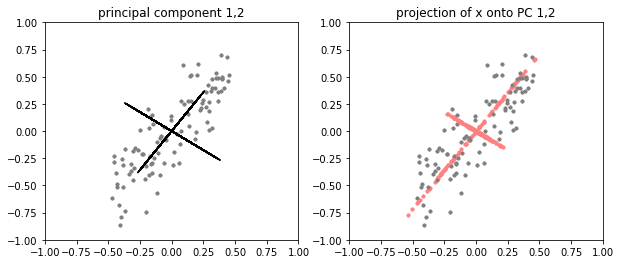

In [10]:
## find first PC
xmean = x.mean(axis=1)[:,np.newaxis]
xsub = x - xmean
sv,u = scipy.sparse.linalg.eigsh(xsub @ xsub.T, k=2)

which_pc = [1,2]
fig = plt.figure(figsize=(10,4)); ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122);
plot_projections(xsub, u, which_pc)


## Principal component analysis (neural example)

In [1]:
# sp is neurons x timepts, find first PC
xmean = sp.mean(axis=1)[:,np.newaxis]
xsub  = sp - xmean
sv,u  = scipy.sparse.linalg.eigsh(xsub @ xsub.T,k=100)

xlowd = u @ (u.T @ xsub)

interact(neural_lowd, d=widgets.IntSlider(min=1,max=101,step=1,continuous_update=False));

NameError: name 'sp' is not defined

## Principal component analysis  =  Singular value decomposition

Singular value decomposition decomposes any matrix M into two orthonormal matrices (U,V) and a diagonal matrix $\Sigma$ (image from wikipedia)

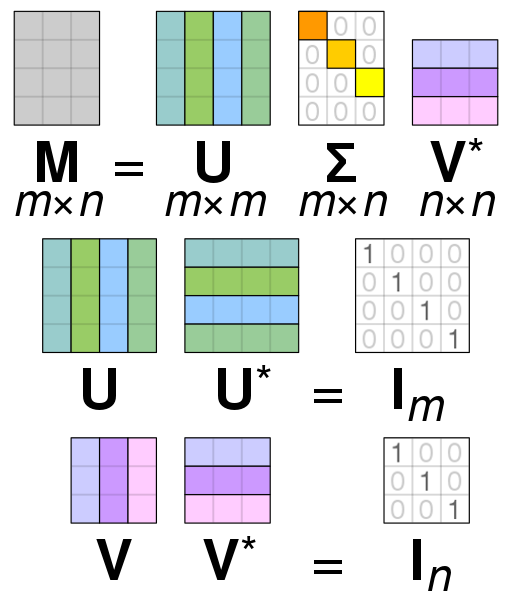

## Principal component analysis  =  Singular value decomposition

Let's assume M is mean-centered (mean of each row of M is 0). Then if

$M = U\Sigma V^\top$

Then this _U_ is the same as the one from PCA (which decomposes the covariance):

$MM^\top = USU^\top$

Proof (plug in M's svd into the covariance):
\begin{align*}
MM^\top &= (U\Sigma V^\top)(U\Sigma V^\top)^\top \\
 &= U\Sigma V^\top V \Sigma^\top U^\top  \qquad \qquad (V^\top V = I) \\
 &= U \Sigma \Sigma^\top U^\top \qquad \qquad \qquad (\Sigma^\top = \Sigma)\\
 &= U \Sigma^2 U^\top
\end{align*}

So the principal components are the same as the singular vectors!

## Principal component analysis 

### Pros
* linear model
* fast (can choose how many PCs to extract, can use covariance to reduce size)

### Cons
* linear model
* extracts positive and negative weights
* forces orthogonal dimensions

**non-negative matrix factorization** is more interpretable in some cases (requires all positive weights)

$X = WH \qquad \text{where } W\ge 0, H\ge 0$ 

## Non-negative matrix factorization (NMF)

Matrix decomposition such that

$X = WH \qquad \text{where } W\ge 0, H\ge 0$ 

Solvers available in scikit-learn. Also can optimize cost function _J_ by gradient descent (after each step manually rectify W and H):

$\min_{W,H} J(W,H) = \min \| X - WH \|^2 = \min X^\top X - 2 X^\top W H + H^\top W^\top W H$

$\frac{\partial J}{\partial H} = -2 X^\top W + 2 W^\top W H \qquad \frac{\partial J}{\partial W} = -2 XH^\top + 2 WHH^\top$

$H_{(t+1)} = H_{(t)} + \eta \frac{\partial J}{\partial H} \qquad \qquad W_{(t+1)} = W_{(t)} + \eta \frac{\partial J}{\partial W}$

## Non-negative matrix factorization (NMF)

In [358]:
import sklearn.decomposition
# sp ~ W @ H
# sp is neurons x timepts, find first PC
model = sklearn.decomposition.NMF(n_components=100, init='nndsvda')
W     = model.fit_transform(sp)
H     = model.components_

interactive(children=(Dropdown(description='d', options=(('PCA', 0), ('NMF', 1), ('original data', 2)), value=…

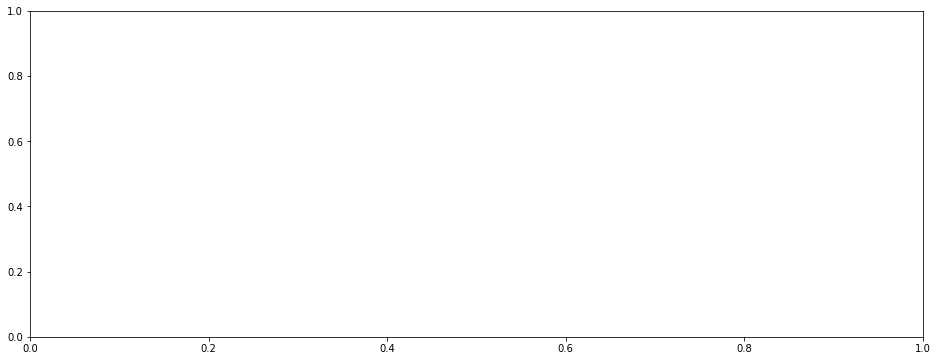

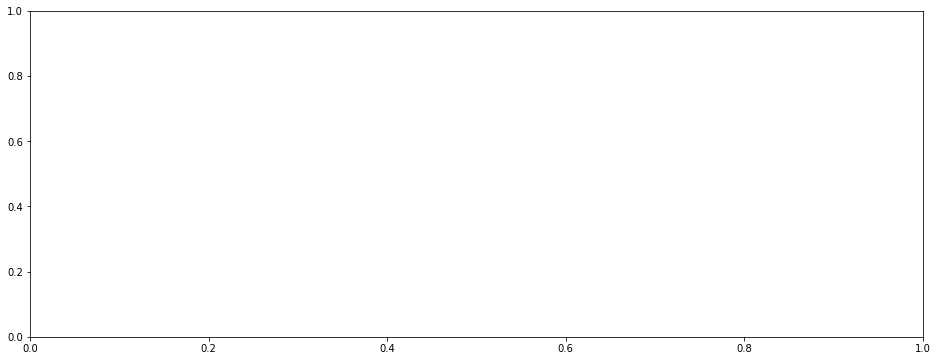

In [12]:
interact(compare_nmf_pca, d=[('PCA',0),('NMF',1),('original data',2)]);

## Non-negative matrix factorization (NMF)

Positivity may not always be the right, or a sufficient criterion for decomposition.

Other criteria:
* sparsity (L0/L1)
* skewness
* temporal smoothness

To find sparse components:
* independent component analysis (ICA)
* sparse coding
* dictionary learning
* Boltzmann machines


## Independent component analysis (ICA)

- assumes independent random variables are mixed
- tries to find demixing matrix W 
- **Model**: x = W<sup>-1</sup>s where s are the independent signals
- IDEA: sum of independent random variables is more Gaussian than each alone (Central Limit Theorem)

- finds maximally **non-Gaussian** components
    - wide range of non-Gaussianity measures
    - most common are kurtosis and skewness (4th and 3rd moments)
    
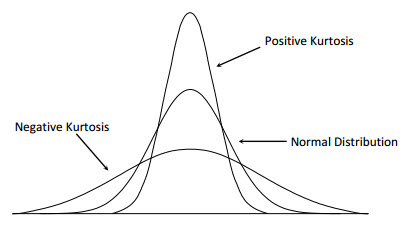


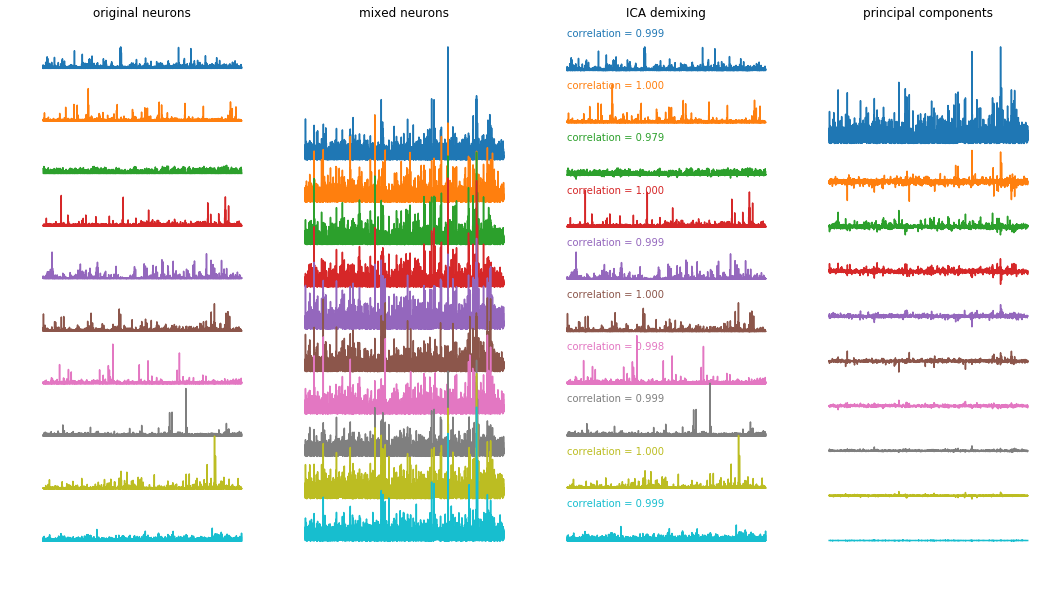

In [15]:
neurons = isort1[np.random.randint(6000, size=(10,))]
ica_example(sp, neurons)

## Independent component analysis (ICA)

The “independent components” of natural scenes are edge filters (Bell & Sejnowski, 1997)

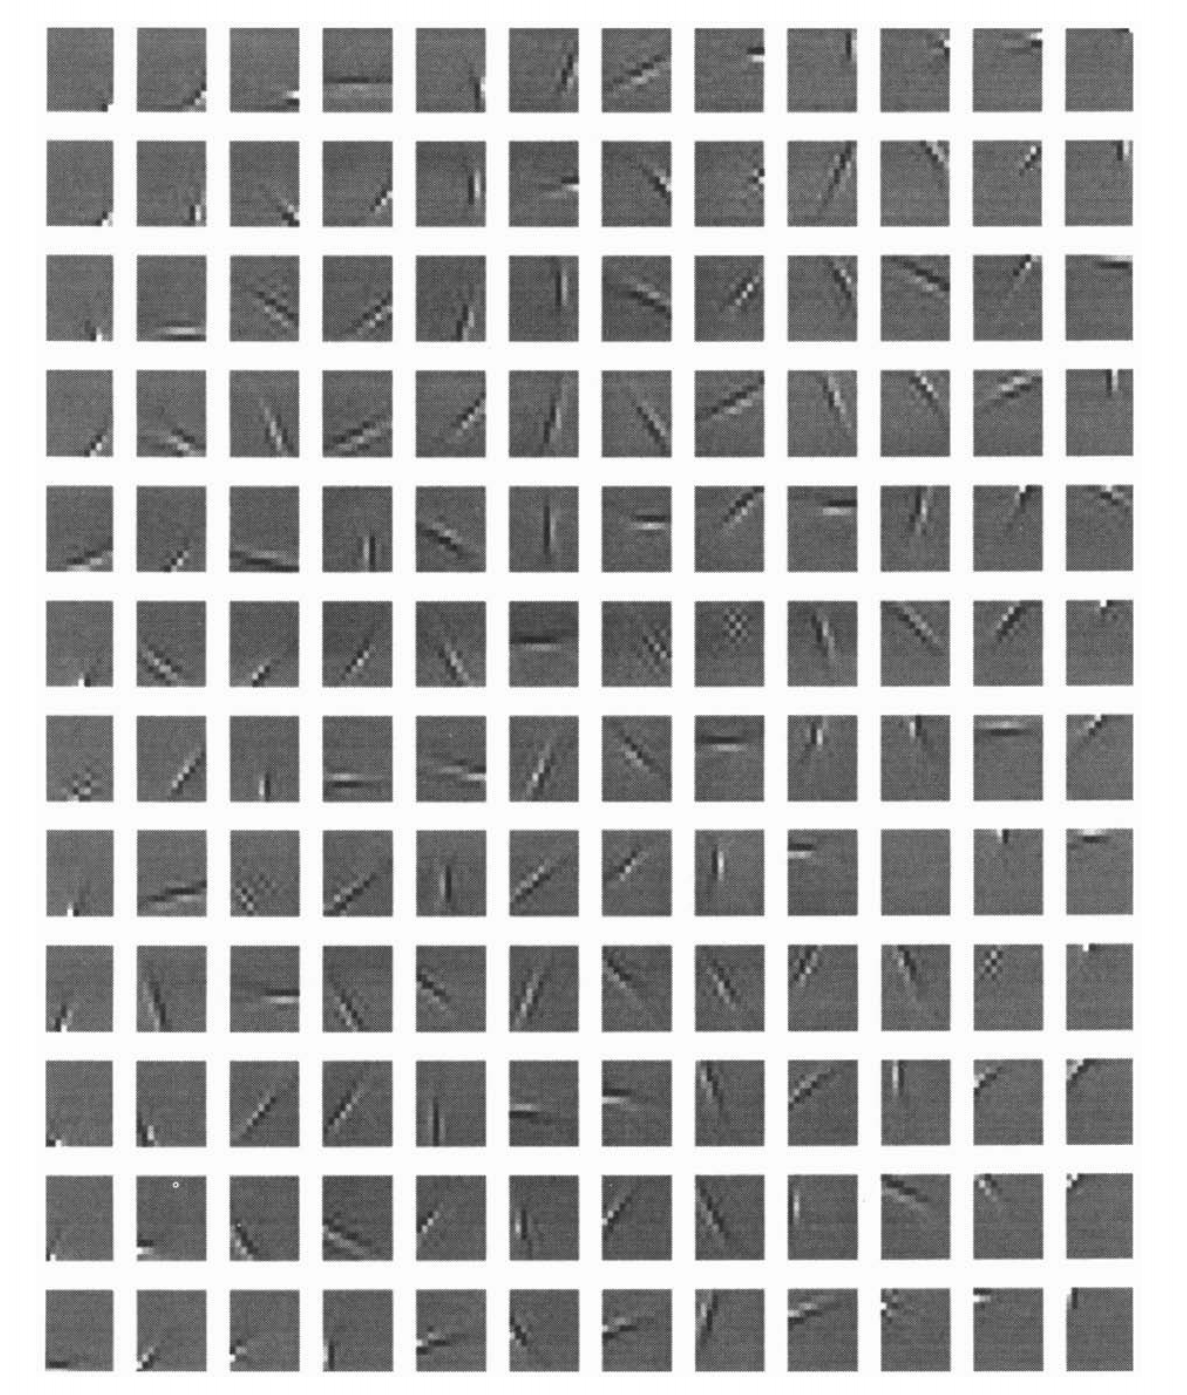


## Independent component analysis (ICA)

FastICA is implemented in scikit-learn (Hyvarinen & Oja, 2000). Steps:

* whiten data: set covariance matrix to identity
    * we now know how to whiten, use SVD!
    \begin{align*}
    \text{from SVD, } X &= U\Sigma V^\top \\
    X_{white} &= UV^\top \\
    \Rightarrow X_{white} X_{white}^\top &= (UV^\top)(UV^\top)^\top = UV^\top V U^\top = UU^\top = I
    \end{align*}

* find <b>w</b> that maximizes non-Gaussianity of projection <b>w<sup>T</sup>X</b>
    * uses negative entropy definition of non-Gaussianity (less susceptible to outliers)

* find next <b>w</b> that maximizes non-Gaussianity of projection <b>w<sup>T</sup>X</b>
    * on each step, force <b>w</b> to be orthogonal to previously found weights

## Independent component analysis (ICA)

### Pros
* finds sparse components

### Cons
* orthogonal dimensions
* still a linear model

t-SNE and uMAP can find non-linear components... let's check them out!

## t-SNE (student's t-distribution stochastic neighbor embedding)

(van der Maaten & Hinton, 2008)
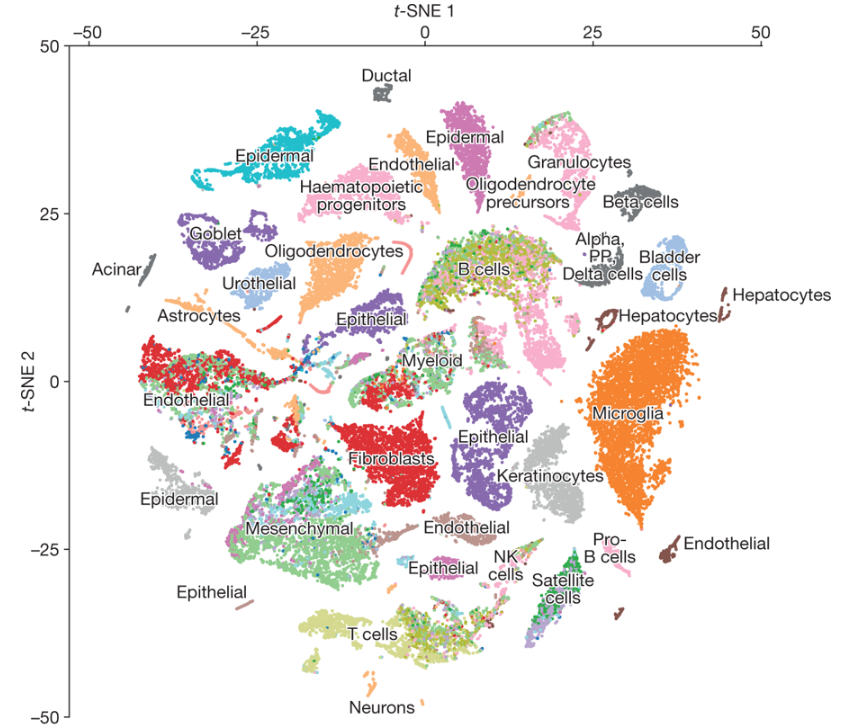


## t-SNE (student's t-distribution stochastic neighbor embedding)

(van der Maaten & Hinton, 2008) Tries to _embed neighbors_ in X near each other in a low-dimensional space Y

The probability that $x_i$ has neighbor $x_j$ is defined as

$p_{j|i} = \left. e^\frac{-\|x_i - x_j\|^2}{2 \sigma^2} \middle/ \sum\limits_{k,l} e^\frac{-\|x_k - x_l\|^2}{2 \sigma^2} \right.$

How much $\sigma$ varies across X is set by the **perplexity**

Probability of being neighbors in X should equal probability of being neighbors in Y
* optimize Y based on this constraint, not an easy optimization
* using the student's t-distribution ensures that neighbors in Y cannot be dissimilar in X
* "early exaggeration" - force tight-knit clusters to separate from each other and move around
    * this is a parameter you can vary (if it's too big it may not converge well)
 

## t-SNE (student's t-distribution stochastic neighbor embedding)

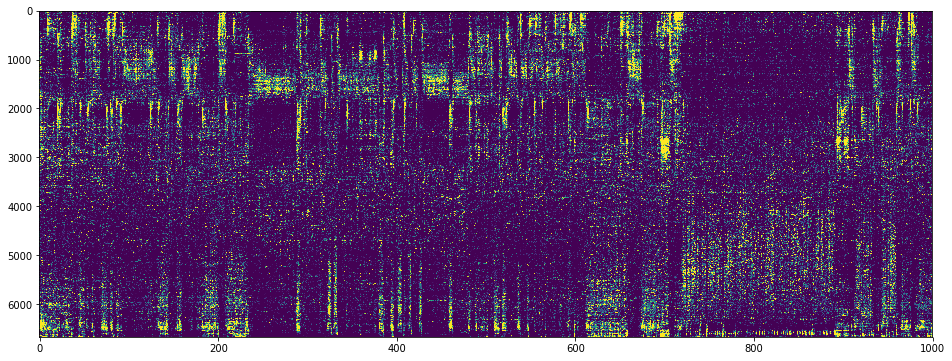

In [389]:
from MulticoreTSNE import MulticoreTSNE as TSNE # fast, multicore implementation by Dimitry Ulyanov
import time

tsne = TSNE(n_components=1, n_jobs=8, perplexity=50, learning_rate=500, n_iter=2000)
out = tsne.fit_transform(sp)
iout = np.argsort(out[:,0])
fig = plt.figure(figsize=(16,6))
plt.imshow(gaussian_filter1d(sp[iout,:1000],5,axis=0),aspect='auto',vmin=.2,vmax=0.7)
plt.show()

## t-SNE (student's t-distribution stochastic neighbor embedding)

spatially localized clusters found!

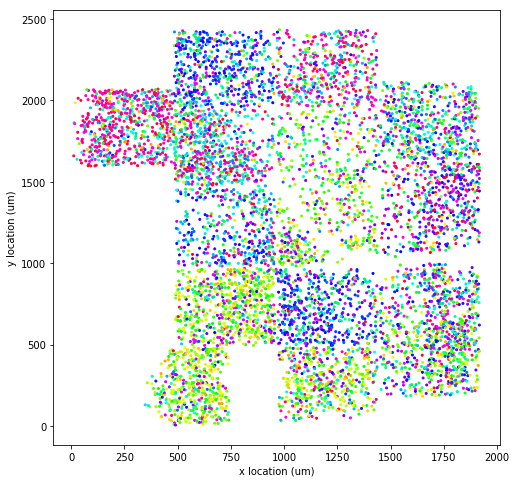

In [398]:
# make a colormap
cmap=matplotlib.cm.get_cmap('hsv'); cmap = cmap(np.linspace(0.1,1,sp.shape[0]))
plt.figure(figsize=(8,8))
# assign color based on t-SNE
plt.scatter(xyloc[:,0],xyloc[:,1],s=4,color=cmap[iout,:])
plt.xlabel('x location (um)'); plt.ylabel('y location (um)');
plt.show()

## t-SNE (student's t-distribution stochastic neighbor embedding)

https://distill.pub/2016/misread-tsne/

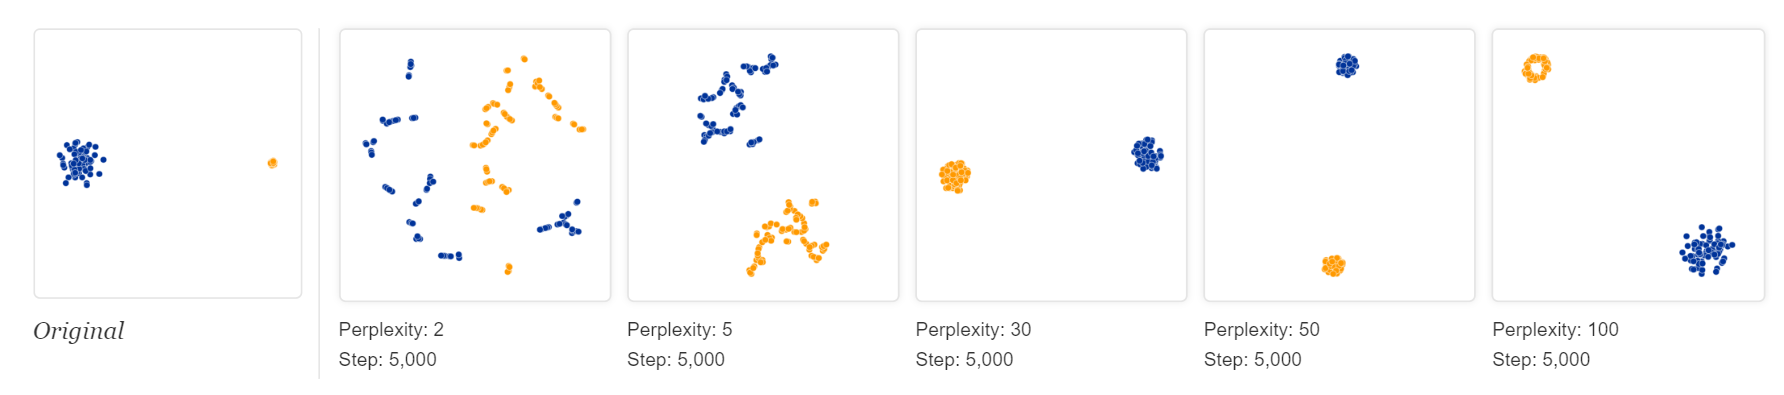



Cluster distances may not mean anything:
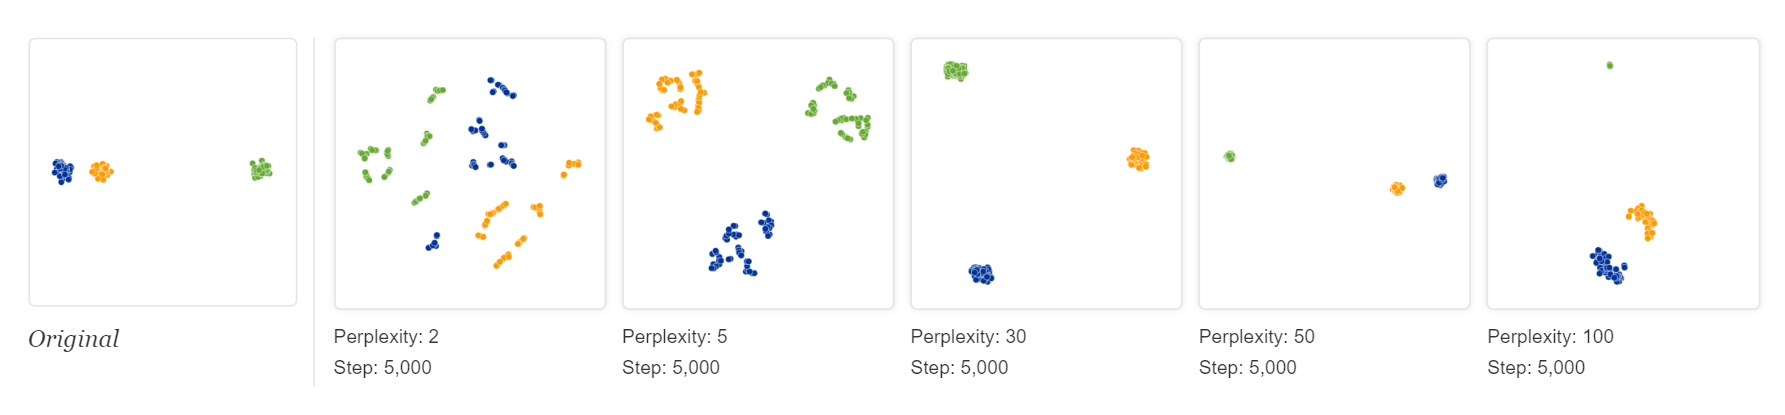


## UMAP (Uniform manifold approximation and projection)

(McInnes & Healy, 2018)

Supposed to preserve more long-range distances (unlike t-SNE)

